# Scenario - Credit Card Approval

In [1]:
import os
import sys
sys.path.insert(1, "../")
try:
    from helpers import save_solution
except Exception as e:
    print(e)

In [7]:
from factsheet import Factsheet
factsheet = Factsheet()

factsheet.set_protected_feature("Group")
factsheet.set_protected_group("lambda x: x[protected_feature] == 1")
factsheet.set_target_column("Target")
factsheet.set_favorable_outcome("lambda x: x[target_column] == 1")

init


In [8]:
# Load all necessary packages
#import os
#import sys
#sys.path.insert(1, "../")  
  
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

import pandas as pd
import sklearn
import pickle
from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from IPython.display import Markdown, display

In [9]:
data = pd.read_csv("./data/data.csv")
data.head(5)

,Num_Children,Group,Income,Own_Car,Own_Housing,Target
0,4,0,36151,0,0,0
1,0,0,36095,1,0,0
2,2,1,62110,1,1,0
3,0,1,73644,1,0,0
4,3,0,99146,0,0,1


In [10]:
target_column = "Target"

In [11]:
X = data.loc[:, data.columns != target_column]
X.head(5)

,Num_Children,Group,Income,Own_Car,Own_Housing
0,4,0,36151,0,0
1,0,0,36095,1,0
2,2,1,62110,1,1
3,0,1,73644,1,0
4,3,0,99146,0,0


In [12]:
y = data.loc[:, data.columns == target_column]
y.head(5)

,Target
0,0
1,0
2,0
3,0
4,1


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Statistical Parity Difference

In [24]:
import operator

target_column = "Target"
favorable_outome = lambda x: x[target_column]==1

protected_feature = "Group"
protected = lambda x: x[protected_feature]==0
protected_indices = data.apply(protected, axis=1)

In [25]:
minority = data[protected_indices]
minority_size = len(minority)
favored_minority = minority[minority.apply(favorable_outome, axis=1)]
favored_minority_size = len(favored_minority)
favored_minority_ratio = favored_minority_size/minority_size
print("{0}/{1} = {2}".format(favored_minority_size, minority_size, favored_minority_ratio))

49389/249675 = 0.1978131571042355


In [26]:
majority = data[~protected_indices]
majority_size = len(majority)
favored_majority = majority[majority.apply(favorable_outome, axis=1)]
favored_majority_size = len(favored_majority)
favored_majority_ratio = favored_majority_size/majority_size
print("{0}/{1} = {2}".format(favored_majority_size, majority_size, favored_majority_ratio))

143924/250325 = 0.574948566863078


In [27]:
statistical_parity_difference = favored_minority_ratio - favored_majority_ratio
print(statistical_parity_difference)

-0.3771354097588425


### 1. SVM

In [ ]:
from sklearn import svm
clf = svm.SVC(verbose=1)
clf.fit(X_train, y_train.values.ravel())

[LibSVM].....

### 2. k-Nearest Neighbors

In [14]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train.values.ravel());

In [15]:
y_pred = clf.predict(X_test)

In [16]:
print(confusion_matrix(y_test,y_pred))

[[58107  3120]
 [ 3371 35402]]


In [17]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     61227
           1       0.92      0.91      0.92     38773

    accuracy                           0.94    100000
   macro avg       0.93      0.93      0.93    100000
weighted avg       0.94      0.94      0.94    100000



In [18]:
error_rate = []

for i in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train.values.ravel())
    y_pred = knn.predict(X_test)
    error_rate.append(np.mean(y_pred != y_test.values.ravel()))

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

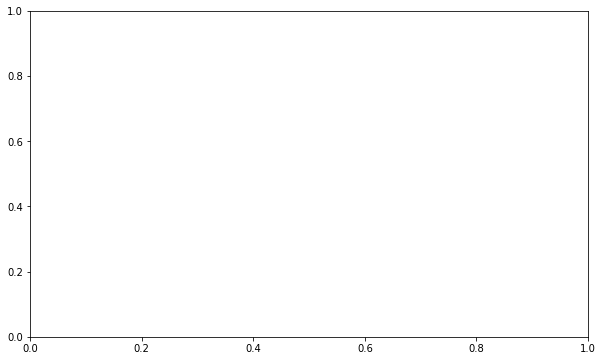

In [19]:
plt.figure(figsize=(10,6))
plt.plot(range(1,11),error_rate,color='blue', linestyle='dashed', marker='o',
 markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [20]:
# NOW WITH K=20
clf_knn_01 = KNeighborsClassifier(n_neighbors=20)
clf_knn_01.fit(X_train,y_train.values.ravel())
pred = clf_knn_01.predict(X_test)

print(confusion_matrix(y_test,pred))

print(classification_report(y_test,pred))

[[57813  3414]
 [ 4666 34107]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     61227
           1       0.91      0.88      0.89     38773

    accuracy                           0.92    100000
   macro avg       0.92      0.91      0.91    100000
weighted avg       0.92      0.92      0.92    100000



In [24]:
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)
save_solution("credit_card_approval", "jans_knn_classifier_01", clf_knn_01, train_data, test_data, factsheet, to_webapp=False)

base directory /Users/jankreischer/Desktop/Masterproject/Shared/scenarios/credit_card_approval/solutions/jans_knn_classifier_01


### Testing Lambda Expressions

In [167]:
var = 3
inc_by_one = eval("lambda x: x+var")
numbers = [1,2,3,4]
result = list(map(inc_by_one, numbers))
print(result)


[4, 5, 6, 7]


In [185]:
import inspect

protected_feature = "Group"
protected = "lambda x: x[protected_feature]==1"
print(protected)
protected = eval(protected, {"protected_feature": protected_feature})
print(protected)

lambda x: x[protected_feature]==1
<function <lambda> at 0x7fc865aead30>


In [186]:
minority = data[data.apply(protected, axis=1)]

In [187]:
minority.head(5)

,Num_Children,Group,Income,Own_Car,Own_Housing,Target
2,2,1,62110,1,1,0
3,0,1,73644,1,0,0
5,0,1,114086,1,0,1
7,2,1,83130,1,1,1
8,2,1,81965,1,0,1
